In [22]:
import numpy as np
import astropy.io.fits as fits
import matplotlib.pyplot as plt
import os
import glob
import PIL.ImageDraw
import PIL.Image
%pylab inline --no-import-all
matplotlib.rcParams['image.origin'] = 'lower'
matplotlib.rcParams['image.interpolation'] = 'nearest' 
matplotlib.rcParams['image.cmap'] = 'gray'

Populating the interactive namespace from numpy and matplotlib


## Set basic parameters

In [706]:
overwrite = False
secobs_key = "WFIRST"
iD = 34
oD = 90
D = 1024
N = 128 # quadrant width after binning
symm = 'half' # set to either 'quart' or 'half'
cobs_diam = 31 # integer central obscuration parameter in range [0, 99]; nominal WFIRST value 31
sthick = 26 # integer strut thickness parameter in range [0, 99]; nominal WFIRST value 26
pad = 50 # feature padding, units of thousandths of pupil diameter
symm = 'half' # set to either 'quart' or 'half'
shape = 'ann'

In [707]:
#LS_dir = os.path.abspath("../InputMasks/LS")
#LS_dir = os.path.normpath("/astro/opticslab1/SCDA/Apertures/InputMasks/LS")
#LS_dir = os.path.normpath("/astro/opticslab1/SCDA/Apertures/InputMasks_v2/LS")
#LS_dir = os.path.normpath("/astro/opticslab1/SCDA/Apertures/InputMasks_v3/LS")
#LS_dir = os.path.normpath("/astro/opticslab1/SCDA/Apertures/InputMasks_v4/LS")
#LS_dir = os.path.normpath("/Users/neil/Box Sync/scda/InputMasks/LS")
#LS_dir = os.path.expanduser("~/Box Sync/scda/InputMasks_wfirst/LS")
LS_dir = os.path.normpath("/astro/opticslab1/SCDA/Apertures/InputMasks_WFIRST/LS")

if not os.path.exists(LS_dir):
    os.mkdir(LS_dir)
    print("created {:s} for LS arrays".format(LS_dir))
else:
    print("Destination {:s} already exists".format(LS_dir))

Destination /astro/opticslab1/SCDA/Apertures/InputMasks_WFIRST/LS already exists


### Define annular stop

In [708]:
xs = np.linspace(-D/2 + 0.5, D/2 - 0.5, D)
[Xs, Ys] = np.meshgrid(xs, xs)
inside_ann = np.less_equal(Xs**2 + Ys**2, (iD/100.*D/2)**2)
outside_ann = np.greater_equal(Xs**2 + Ys**2, (oD/100.*D/2)**2)
annular_stop = np.ones((D,D))
annular_stop[inside_ann] = 0.
annular_stop[outside_ann] = 0.

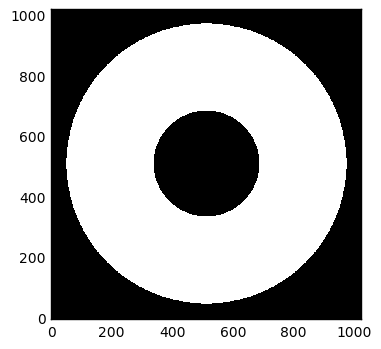

In [709]:
plt.imshow(annular_stop)

### Define strut pattern

In [710]:
xcent = D/2-0.5; ycent = D/2-0.5

#xycent_01 = (xcent + 75.2, ycent + 0.)
#strut_01 = matplotlib.patches.Rectangle(xycent_01, 25.90*D/1000., D, angle=-12.418)
xycent_01 = (xcent + 75.0, ycent + 0.)
strut_01 = matplotlib.patches.Rectangle(xycent_01, float(sthick)*D/1000., D, angle=-12.418)
strut_verts_01 = strut_01.get_verts()

#xycent_02 = (xcent, ycent + 107.7)
#strut_02 = matplotlib.patches.Rectangle(xycent_02, 26.4*D/1000., D, angle=-107.6)
xycent_02 = (xcent, ycent + 107.7)
strut_02 = matplotlib.patches.Rectangle(xycent_02, float(sthick)*D/1000., D, angle=-107.6)
strut_verts_02 = strut_02.get_verts()

#xycent_03 = (xcent, ycent - 97.6)
#strut_03 = matplotlib.patches.Rectangle(xycent_03, 25.95*D/1000., D, angle=-132.4)
xycent_03 = (xcent, ycent - 97.6)
strut_03 = matplotlib.patches.Rectangle(xycent_03, float(sthick)*D/1000., D, angle=-132.4)
strut_verts_03 = strut_03.get_verts()

strut_img = PIL.Image.new('L', (D,D), 1)
PIL.ImageDraw.Draw(strut_img).polygon(list(strut_verts_01.ravel()), outline=0, fill=0)
PIL.ImageDraw.Draw(strut_img).polygon(list(strut_verts_02.ravel()), outline=0, fill=0)
PIL.ImageDraw.Draw(strut_img).polygon(list(strut_verts_03.ravel()), outline=0, fill=0)
strut_mask = np.round(np.array(strut_img))

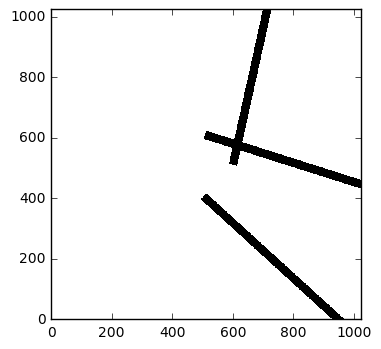

In [711]:
plt.imshow(strut_mask)

### Pad the struts

In [712]:
max_shift = int(round(D*float(pad)/1000))
shift_range = range(-max_shift,max_shift+1,1)

In [713]:
[Xshifts, Yshifts] = np.meshgrid(shift_range, shift_range)
allowed_shifts = np.less_equal(Xshifts**2 + Yshifts**2, max_shift**2)
allowed_shifts.shape

(27, 27)

In [714]:
XYshifts_allowed = zip(Xshifts[allowed_shifts], Yshifts[allowed_shifts])
len(XYshifts_allowed)

529

In [715]:
padded_strut_mask = np.ones(strut_mask.shape)
for (xshift,yshift) in XYshifts_allowed:
    strut_mask_shifted = np.roll(np.roll(strut_mask, yshift, 0), xshift, 1) 
    padded_strut_mask *= strut_mask_shifted

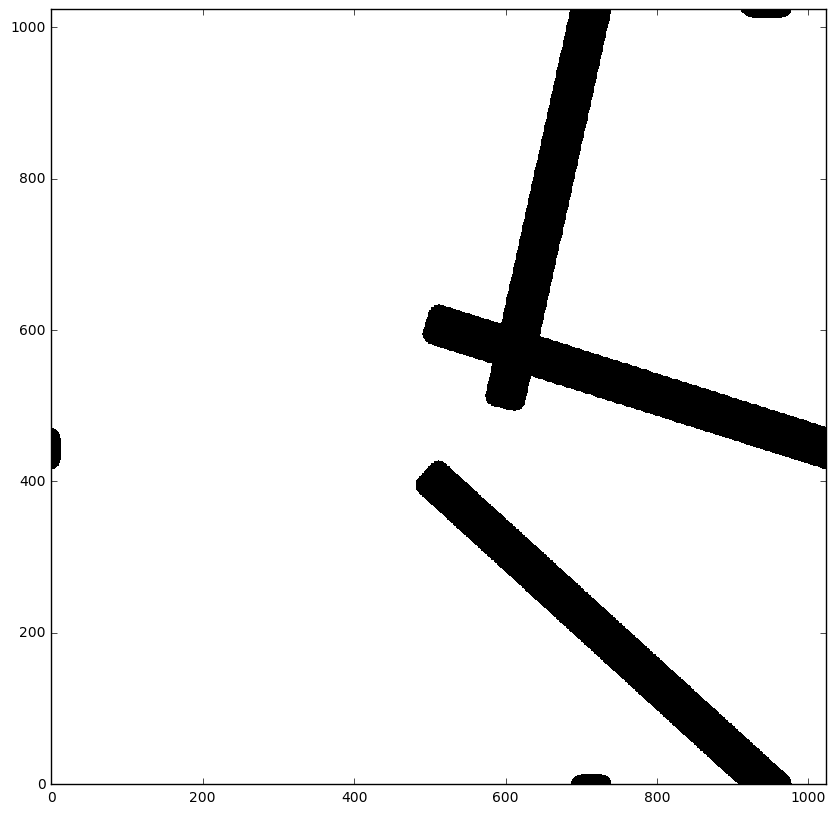

In [716]:
plt.figure(figsize=(10,10))
plt.imshow(padded_strut_mask)

In [717]:
if sthick > 0:
    wfirst_par_LS = padded_strut_mask*padded_strut_mask[:,::-1]*annular_stop
else:
    wfirst_par_LS = annular_stop

In [718]:
Lyot_stop = np.copy(wfirst_par_LS[::-1,:])

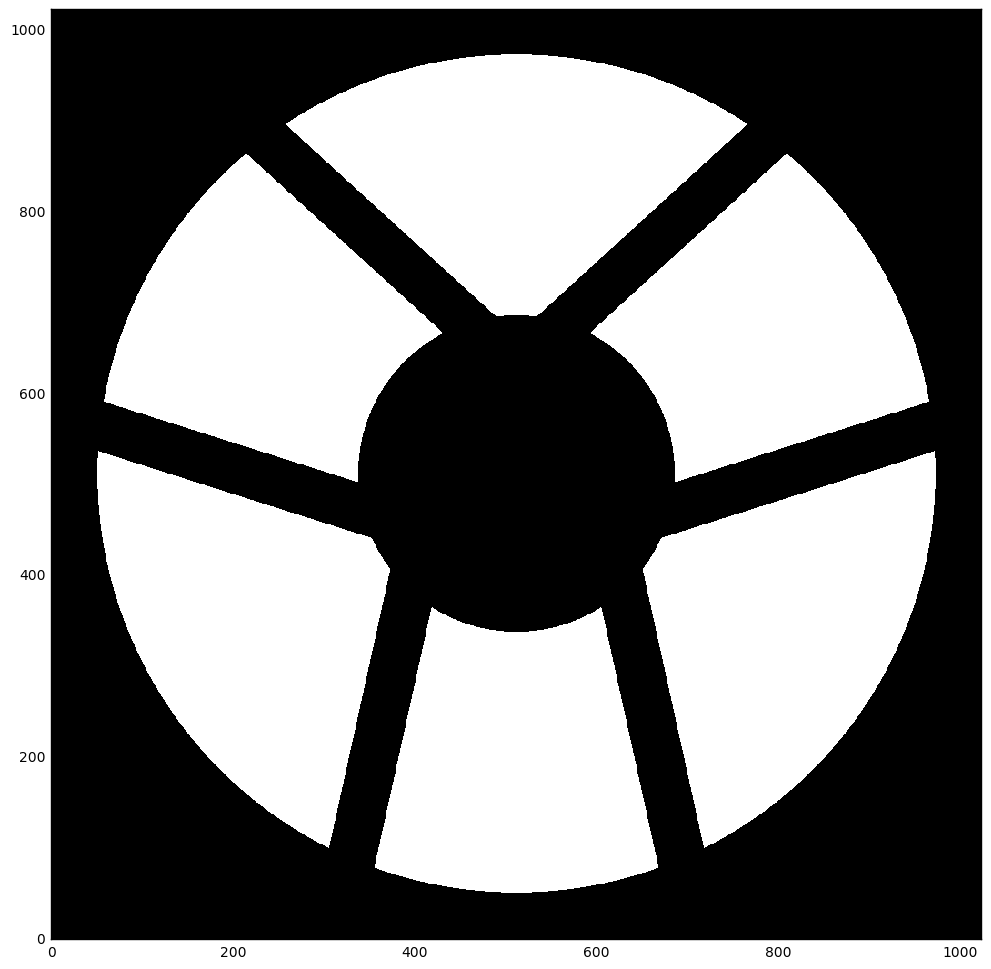

In [719]:
plt.figure(figsize=(12,12))
plt.imshow(Lyot_stop)

## Bin to final array resolution, crop

In [720]:
N_orig = D/2
scalefac = int(N_orig/N)
print("Binning the original LS array {0:d}x".format(scalefac))
Lyot_stop_binned = np.reshape(Lyot_stop, (Lyot_stop.shape[0]/scalefac, scalefac,
                                          Lyot_stop.shape[1]/scalefac, scalefac)).mean(1).mean(2)

Binning the original LS array 4x


In [721]:
L_bin = Lyot_stop_binned.shape[0]

Lyot_stop_binned_crop = Lyot_stop_binned[L_bin/2-N:L_bin/2+N,L_bin/2:L_bin/2+N]
Lyot_stop_binned_crop_binary = np.round(Lyot_stop_binned_crop).astype(int)
print(Lyot_stop_binned_crop.shape)

Lyot_stop_full_binary = np.round(Lyot_stop_binned[L_bin/2-N:L_bin/2+N,L_bin/2-N:L_bin/2+N]).astype(int)

(256, 128)


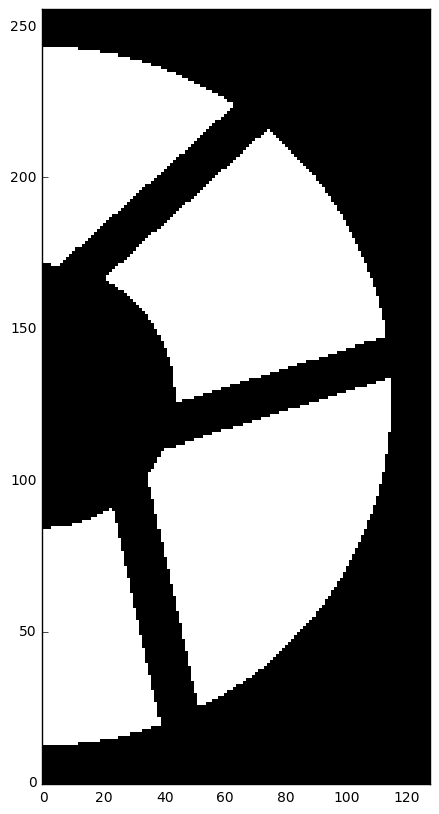

In [722]:
plt.figure(figsize=(20,10))
plt.imshow(Lyot_stop_binned_crop_binary)

## Write the binned, cropped Lyot stop to a dat (ASCII) file 

In [723]:
LS_dat_fname_tail = "LS_half_{0:s}{1:02d}D{2:02d}_{3:s}{4:03d}Pad{5:02d}_N{6:04d}.dat".format(
                         shape, iD, oD, secobs_key, 10*sthick, pad, N)

LS_dat_fname = os.path.join(LS_dir, LS_dat_fname_tail)

if not os.path.exists(LS_dat_fname) or overwrite==True:
    #np.savetxt(LS_dat_fname, Lyot_stop_binned_crop, fmt='%.6f', delimiter=" ")
    np.savetxt(LS_dat_fname, Lyot_stop_binned_crop_binary, fmt='%d', delimiter=" ")
    print("Wrote binned, cropped LS array to {0:s}".format(LS_dat_fname))
else:
    print("LS array {0:s} already exists, will not overwrite".format(LS_dat_fname))

Wrote binned, cropped LS array to /astro/opticslab1/SCDA/Apertures/InputMasks_WFIRST/LS/LS_half_ann34D90_WFIRST260Pad13_N0128.dat


In [724]:
#os.listdir(LS_dir)
#glob.glob('{:s}/LS_half_*WFIRST260Pad00_N0128.dat'.format(LS_dir))
#glob.glob('{:s}/LS_half_*WFIRST260Pad01_N0128.dat'.format(LS_dir))
#glob.glob('{:s}/LS_half_*WFIRST260Pad02_N0128.dat'.format(LS_dir))
#glob.glob('{:s}/LS_half_*WFIRST260Pad03_N0128.dat'.format(LS_dir))
glob.glob('{:s}/LS_half_*WFIRST260Pad*_N0128.dat'.format(LS_dir))

['/astro/opticslab1/SCDA/Apertures/InputMasks_WFIRST/LS/LS_half_ann32D90_WFIRST260Pad01_N0128.dat',
 '/astro/opticslab1/SCDA/Apertures/InputMasks_WFIRST/LS/LS_half_ann32D90_WFIRST260Pad03_N0128.dat',
 '/astro/opticslab1/SCDA/Apertures/InputMasks_WFIRST/LS/LS_half_ann32D92_WFIRST260Pad01_N0128.dat',
 '/astro/opticslab1/SCDA/Apertures/InputMasks_WFIRST/LS/LS_half_ann32D94_WFIRST260Pad03_N0128.dat',
 '/astro/opticslab1/SCDA/Apertures/InputMasks_WFIRST/LS/LS_half_ann34D86_WFIRST260Pad01_N0128.dat',
 '/astro/opticslab1/SCDA/Apertures/InputMasks_WFIRST/LS/LS_half_ann34D86_WFIRST260Pad03_N0128.dat',
 '/astro/opticslab1/SCDA/Apertures/InputMasks_WFIRST/LS/LS_half_ann32D86_WFIRST260Pad01_N0128.dat',
 '/astro/opticslab1/SCDA/Apertures/InputMasks_WFIRST/LS/LS_half_ann32D92_WFIRST260Pad03_N0128.dat',
 '/astro/opticslab1/SCDA/Apertures/InputMasks_WFIRST/LS/LS_half_ann32D94_WFIRST260Pad01_N0128.dat',
 '/astro/opticslab1/SCDA/Apertures/InputMasks_WFIRST/LS/LS_half_ann32D86_WFIRST260Pad03_N0128.dat',


In [725]:
#os.remove(LS_dat_fname)